In [1]:
## Run when initialise the code
import os

import geopandas as gpd
import osmnx as ox
from geopandas import GeoDataFrame, GeoSeries
from osmnx import io
import glob
import pickle
project_crs = 'epsg:3857'
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon, Point, LineString, MultiPolygon, MultiPoint
import math
import warnings
import pandas as pd
import shutil
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')
from momepy import remove_false_nodes, extend_lines
from itertools import combinations
pjr_loc = os.path.dirname(os.getcwd())
import ast  # to convert str with list to list of string
import sys

from pandas import DataFrame

# NEW
import numpy as np
from math import log2

In [2]:
## Choose locations and create folders if necessary

place = 'Turin'
print(place)
data_folder  = f'{pjr_loc}/places/{place.replace(",","_").replace(" ","_")}_test'
os.makedirs(f'{data_folder}/delete_2_nodes',exist_ok = True)
os.makedirs(f'{data_folder}/split_tp_intersection',exist_ok = True)
if place =='Tel Aviv':
    useful_tags_path = ['name:en','highway','length','bearing','tunnel','junction']
    ox.utils.config(useful_tags_way=useful_tags_path)


Turin


In [ ]:
# Download data
graph = ox.graph_from_place(place, network_type='all')
graph = ox.bearing.add_edge_bearings(graph, precision=1)
graph_pro = ox.projection.project_graph(graph, to_crs=project_crs)
io.save_graph_geopackage(graph_pro, filepath=f'{data_folder}/osm_data.gpkg', encoding='utf-8', directed=False)

In [4]:
## Filter out polylines and calculate angles
my_gdf = gpd.read_file(f'{data_folder}/osm_data.gpkg',
                       layer='edges')  # Identify roundabout elements, if any exist, and store them in a separate DataFrame.
if place =='Tel Aviv':
    my_gdf.rename(columns={'name:en':'name'}, inplace=True)

is_junction = True if 'junction' in my_gdf.columns else False
if is_junction:
    round_about = my_gdf[my_gdf['junction'].isin(['roundabout', 'circular'])]
    my_gdf = my_gdf[~((my_gdf['junction'] == 'roundabout') | (my_gdf['junction'] == 'circular'))]
to_remove = my_gdf[~((my_gdf['highway'] == 'motorway') | (my_gdf['highway'] == 'trunk')| (my_gdf['highway'] == 'motorway_link')| (my_gdf['highway'] == 'motorway_link')| (my_gdf['highway'] == 'trunk_link'))]
# Eliminate polylines that lack a name and calculate angles ranging from 0 to 180 degrees based on the bearing field.
df_pro = to_remove.to_crs(project_crs).dropna(subset=['name'])
df_pro = df_pro[df_pro['name']!='']
df_pro['angle'] = df_pro['bearing'].apply(lambda x: x if x < 180 else x - 180)
df_pro['length'] = df_pro.length

 # Function to convert valid list strings to lists
def convert_to_list(s):
    try:
        return ast.literal_eval(s)[0]
    except (ValueError, SyntaxError,TypeError):
        return s  # Return the original string if conversion fails

# Apply the function to the DataFrame column so polylines with several street names will return the first name.
df_pro['name'] = df_pro['name'].apply(convert_to_list)
df_pro['highway'] = df_pro['highway'].apply(convert_to_list)

In [ ]:
# Detect multi lanes' scenario
# DBSCAN and first initial filtering
# group the street segments by street name
my_groupby = df_pro.groupby('name')
dic_final = {'name': [], 'geometry': [], 'highway': [], 'bearing': [], 'group': [],'is_simplified':[]}
# Street to test - name = 'Corso Orbassano', '18','Corso Vercelli','Piazza Giuseppe Luigi Lagrange','Corso Peschiera',,'Corso Giambattista Beccaria','Corso Re Umberto',
# new to test = 'Corso Valdocco','Corso Ottone Rosai','Via Treviso','Strada del Fortino'
name = 'Corso Quintino Sella'
res = my_groupby.get_group(name)
res = res.dropna(subset=['angle'], axis=0)
if len(res) < 2:
    data = res
    _  = res['geometry'].apply(lambda x:update_df_with_center_line(x))
# Use DBSCAN to classify streets based on their angle, and group each class. Outliers could not consider parallel with any street, thus removed
res['group'] = DBSCAN(eps=10, min_samples=2).fit(res['angle'].to_numpy().reshape(-1, 1)).labels_
res

In [17]:
# if all is -1, don't touch the element
if (res['group']== -1).all():
    data = res
    _  = res['geometry'].apply(lambda x:update_df_with_center_line(x))
# check parallelism for one street. We create buffer around each polyline and also translate the buffer. If 10% of at least  one of  the translated polylines is overlay with the buffer it is multi lanes  scenarios
angels_groups = res.groupby('group')
data  = angels_groups.get_group(0)
data.explore()

In [16]:
# test gruups
res.value_counts('group')

group
 0    20
 1     7
-1     2
 2     2
dtype: int64

In [180]:
data

,u,v,key,osmid,oneway,name,highway,reversed,length,bearing,...,bridge,maxspeed,junction,service,tunnel,ref,width,geometry,angle,group
4291,248160675,1369857464,0,"[106695424, 106759979]",True,Piazza Giuseppe Luigi Lagrange,service,False,19.883200,297.0,...,,,,,building_passage,,,"LINESTRING (854975.401 5631547.149, 854971.248...",117.0,0
4303,2018127896,2028069892,0,"[572748505, 649703378]",True,Piazza Giuseppe Luigi Lagrange,service,False,36.527693,120.8,...,,,,parking_aisle,,,,"LINESTRING (854982.280 5631525.951, 854981.212...",120.8,0
4305,248160735,1369857462,0,"[106760014, 106759983]",True,Piazza Giuseppe Luigi Lagrange,service,False,19.984440,117.5,...,,,,,building_passage,,,"LINESTRING (854950.398 5631542.310, 854963.857...",117.5,0
4310,1369857462,2028069892,0,"[106760014, 23016551]",True,Piazza Giuseppe Luigi Lagrange,service,False,15.851596,116.7,...,,,,,building_passage,,,"LINESTRING (854968.120 5631533.074, 854975.245...",116.7,0
4326,248160760,1369857464,0,"[106759979, 192249357]",True,Piazza Giuseppe Luigi Lagrange,service,False,15.986236,297.2,...,,,,,building_passage,,,"LINESTRING (854989.616 5631539.836, 854982.458...",117.2,0


In [32]:
# See if there are parallel lines
to_translate = data.copy()
my_buffer = to_translate['geometry'].buffer(cap_style=2, distance=30, join_style=3)
to_translate['geometry_right'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'right'))
to_translate['geometry_left'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'left')) # we need to offset by both sides since the parallel lines could be in opposite directions
def length_of_parallel(my_s_join: GeoDataFrame, the_buffer: GeoSeries, geo_field: str):
    my_s_join['geometry'] = my_s_join[geo_field]
    new_data_0 = my_s_join.sjoin(GeoDataFrame(geometry=the_buffer, crs=project_crs), how='inner').reset_index()
    if not len(new_data_0):
        return False
    new_data_1= new_data_0[new_data_0['index'] != new_data_0['index_right']] # Remove overlay of polylines with its buffer
    for translated_line in new_data_1.iterrows():
        translated_line = translated_line[1]
        geo_tr_line =GeoDataFrame(data= pd.DataFrame([translated_line]),crs=project_crs)
        overlay = gpd.overlay(geo_tr_line, GeoDataFrame(geometry=the_buffer.loc[geo_tr_line['index_right']], crs=project_crs), how='intersection')
        if (overlay.length/translated_line.length).iloc[0]*100>10:
            return True
    return False

if length_of_parallel(to_translate, my_buffer, 'geometry_right'):
    print(1)

else:
    if length_of_parallel(to_translate, my_buffer, 'geometry_left'):
        print(1)
    else:
        print(-1)


1


In [31]:

to_translate['geometry_left'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'left'))

In [ ]:
my_s_join= to_translate
the_buffer=
geo_field=

In [10]:
# Functions and classes to be utilized - Module 3
def update_list(line_local):
    """
    add the first start/end point into the list
    :param line_local:
    :return:
    """
    list_pnts_of_line_group.extend([Point(line_local.coords[0]), Point(line_local.coords[-1])])
def add_more_pnts_to_new_lines(pnt_f_loc: Point, pnt_l_loc: Point, line_pnts: list, lngth_chck: float, test_poly:GeoDataFrame) -> list:
    """
    This method checks if more points should be added to the new lines by checking along the new line if the distance to the old network roads are more than 10 meters
    :param test_poly: From these polylines find the closet one in each interation
    :param lngth_chck: Used latter to find how many checks should be done
    :return:
    """
    # Calculate distance and azimuth between the first and last point
    dist = pnt_f_loc.distance(pnt_l_loc)
    x_0 = pnt_f_loc.coords[0][0]
    y_0 = pnt_f_loc.coords[0][1]
    bearing = math.atan2(pnt_l_loc.coords[0][0] - x_0, pnt_l_loc.coords[0][1] - y_0)
    bearing = bearing + 2 * math.pi if bearing < 0 else bearing
    # Calculate the number of  checks going to carry out
    loops = int(dist / lngth_chck)
    # Calculate  the first point over the line
    for dis_on_line in range(1, loops):
        x_new = x_0 + lngth_chck * dis_on_line * math.sin(bearing)
        y_new = y_0 + lngth_chck * dis_on_line * math.cos(bearing)
        # S_joins to all the network lines (same name and group)
        # if the distance is less than 10 meters continue, else: find the projection point and add it to the correct location and run the function agein
        one_pnt_df = GeoDataFrame(geometry=[Point(x_new, y_new)], crs=project_crs)
        try:
            s_join_loc = one_pnt_df.sjoin_nearest(test_poly, distance_col='dis').iloc[0]
        except RecursionError:
            print('error')
            return line_pnts

        if s_join_loc['dis'] > 10:
            line = data.loc[s_join_loc['index_right']]['geometry']
            pnt_med= line.interpolate(line.project( s_join_loc['geometry']))
            if pnt_med.distance(pnt_f_loc)<10: # Otherwise the code may stack in endless loops
                continue
            line_pnts.append(pnt_med)
            return add_more_pnts_to_new_lines(pnt_med, pnt_l_loc, line_pnts,lngth_chck,test_poly)
    return line_pnts
def update_df_with_center_line(new_line,is_simplified=0,group_name= -1):
    """
    update our dictionary with new lines
    :param is_simplified:
    :param new_line:
    :param group_name: According to the DBSCAN algorithm, if no =-1
    :return:
    """
    dic_final['name'].append(name)
    # dic_final['geometry'].append(LineString(coordinates=(pnt_list[max_dis[0]], pnt_list[max_dis[1]])))
    dic_final['geometry'].append(new_line)
    dic_final['highway'].append(data.iloc[0]['highway'])
    dic_final['bearing'].append(data['angle'].mean())
    dic_final['group'].append(group_name)
    dic_final['is_simplified'].append(is_simplified)

In [11]:
# Create buffer around the polyline and unify them #
min_num_of_polylines = len(data)/10
# Use a single boolean condition for filtering
condition = (data['highway'].isin(['service','unclassified'])) & (data.groupby('highway')['highway'].transform('count') <= min_num_of_polylines)
data = data[~condition]

# unify lines to one polygon
buffers = data.buffer(cap_style=3, distance=30, join_style=3)
one_buffer = buffers.unary_union


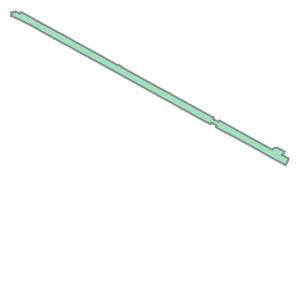

In [12]:
one_buffer

In [207]:
time_00 =time.time()
time_0 = time.time()
#  Create centerline
# Get all the polylines intersected with the new polygon
one_poly= one_buffer
lines_in_buffer = data.sjoin(GeoDataFrame(geometry=[one_poly],crs=project_crs)).drop(columns='index_right')

list_pnts_of_line_group = []

# Get the start/end points of these polylines
lines_in_buffer['geometry'].apply(update_list)
print(f'Get the start/end points of these polylines:{time.time() -time_0} ')
time_0 = time.time()

# Find all the unidirectional combinations between each two pair of points
point_combinations = list(combinations(list_pnts_of_line_group, 2))
print(f'Find all the unidirectional combinations between each two pair of points:{time.time() -time_0} ')
time_0 = time.time()

# Save it into DataFrame frame and calculate distance
df_test= DataFrame()
df_test['point_1'] = [pair[0] for pair in point_combinations]
df_test['point_2'] = [pair[1] for pair in point_combinations]
df_test['dist'] = df_test.apply(lambda x:x['point_1'].distance(x['point_2']),axis=1)
print(f'Save it into Geodata frame and calculate distance and angle (0 and 180):{time.time() -time_0} ')
time_0 = time.time()


# Calculate  angle (0 and 180)
# Calculate angle using vectorized operations
# Vectorized angle calculation using NumPy
dx = df_test['point_2'].apply(lambda p: p.x)  - df_test['point_1'].apply(lambda p: p.x)
dy = df_test['point_2'].apply(lambda p: p.y)  - df_test['point_1'].apply(lambda p: p.y)
df_test['angle'] = np.degrees(np.arctan2(dy, dx))
df_test['angle']  = np.where(df_test['angle'] > 0, df_test['angle'], df_test['angle'] + 180)

print(f'Calculate distance and angle (0 and 180):{time.time() -time_0} ')
time_0 = time.time()
# Calculate the best two points by looking on their distance and angle. we compare the angle to the polylines angles
avg= lines_in_buffer['angle'].mean()
dis = abs(df_test['angle'] -avg)
df_test['ratio'] = df_test['dist']/df_test['dist'].max() + 0.5*dis /dis.max()
max_points = df_test.sort_values(by='ratio',ascending=False).iloc[0]
print(f'Calculate the best two points by looking on their distance and angle:{time.time() -time_0} ')


# These points will be served to be initial reference in order to find more points
pnt_f = max_points['point_1']
pnt_l = max_points['point_2']
print(f'tot:{time.time() -time_00} ')


Get the start/end points of these polylines:0.023071765899658203 
Find all the unidirectional combinations between each two pair of points:0.006531238555908203 
Save it into Geodata frame and calculate distance and angle (0 and 180):1.093278408050537 
Calculate distance and angle (0 and 180):1.4851412773132324 
Calculate the best two points by looking on their distance and angle:0.006983518600463867 
tot:2.6160030364990234 


In [211]:
time_0 = time.time()

# Add more vertices
angl_rng = lines_in_buffer['angle'].max() - lines_in_buffer['angle'].min()
if angl_rng <1: # If the angel range is less than 1 degree the line will be based on the first and last points
        lines_pnt_geo = [pnt_f]
else:
    if angl_rng > 100: # Maximum of length to check is every 10 meters
        length_to_check  =10
    else:
        length_to_check  =75-log2(angl_rng)*10 # The range of  length_to_check (logarithm to create more changes at the beginning)
    lines_pnt_geo = add_more_pnts_to_new_lines(pnt_f, pnt_l, [pnt_f],length_to_check,lines_in_buffer)
lines_pnt_geo.append(pnt_l)
print(f'Add more vertices:{time.time() -time_0} ')
# Update dic_final

Add more vertices:2.07519793510437 


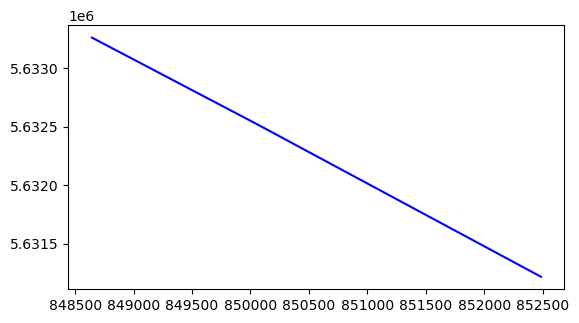

In [214]:
# Draw for test
# data.plot(color ='red')
# ax= GeoDataFrame(geometry=[one_poly],crs=project_crs).plot(edgecolor='blue', linewidth=2.0, facecolor='none')

# GeoDataFrame(geometry=[pnt_f,pnt_l],crs=project_crs).plot(ax= ax, color='red')
# GeoDataFrame(geometry=lines_pnt_geo,crs=project_crs).plot(ax=ax,color ='red')
ax= GeoDataFrame(geometry=[LineString(lines_pnt_geo)],crs=project_crs).plot( color ='blue')
# GeoDataFrame(geometry=[LineString([pnt_f,pnt_l])],crs=project_crs).plot(ax=ax,color ='orange')
# GeoDataFrame(geometry=[pnt_f,pnt_l],crs=project_crs).plot(ax= ax, color='red')

In [ ]:
#  Store for test
data_store =f'{data_folder}/add_more_points_to_line/'
lines_in_buffer.to_file(f'{data_store}lines.shp')
GeoDataFrame(geometry=[LineString([pnt_f,pnt_l])],crs=project_crs).to_file(f'{data_store}new_line.shp')
GeoDataFrame(geometry=[LineString(lines_pnt_geo)],crs=project_crs).to_file(f'{data_store}all_line.shp')
GeoDataFrame(geometry=lines_pnt_geo,crs=project_crs).to_file(f'{data_store}pnts.shp')

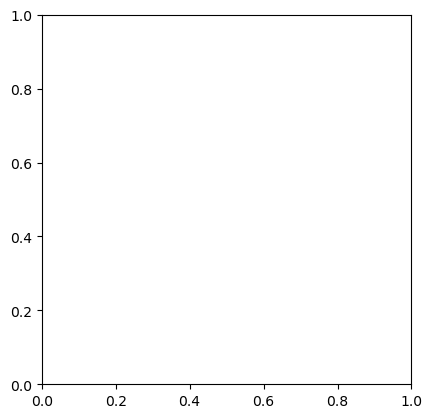

In [178]:
# Plot more results
ax = data.plot(color ='blue')
# ax= lines_in_buffer.plot(color ='yellow')
# GeoDataFrame(geometry=[LineString(lines_pnt_geo)],crs=project_crs).plot(ax=ax,color ='orange')
# GeoDataFrame(geometry=[one_poly],crs=project_crs).plot(ax=ax,edgecolor='blue', linewidth=2.0, facecolor='none')
# GeoDataFrame(geometry=[pnt_f,pnt_l],crs=project_crs).plot(ax= ax, color='red')
# #
# GeoDataFrame(geometry=[LineString([pnt_f,pnt_l])],crs=project_crs).plot(ax=ax,color ='brown')
# lines_in_buffer.plot(ax=ax,color ='yellow')

In [215]:
# More visualizations  for test
data_store = f'{data_folder}/add_more_points_to_line/{name}/'
os.makedirs(data_store,exist_ok = True)

GeoDataFrame(geometry=[LineString(lines_pnt_geo)],crs=project_crs).to_file(f'{data_store}final_line.shp')
GeoDataFrame(geometry=[one_poly],crs=project_crs).to_file(f'{data_store}one_poly.shp')

# ax= GeoDataFrame(geometry=[one_poly],crs=project_crs).plot(edgecolor='blue', linewidth=2.0, facecolor='none')
# GeoDataFrame(geometry=[pnt_f,pnt_l],crs=project_crs).plot(ax= ax, color='red')
GeoDataFrame(geometry=lines_pnt_geo,crs=project_crs).to_file(f'{data_store}new_lines_pnt.shp')
lines_in_buffer.to_file(f'{data_store}lines_in_buffer.shp')
GeoDataFrame(geometry=[LineString([pnt_f,pnt_l])],crs=project_crs).to_file(f'{data_store}first_line.shp')

In [ ]:
# test intersection - update names
# Start from here
with open(f'{data_folder}/intersection/network_2.pkl', "rb") as f:
    df1= pickle.load(f)
with open(f'{data_folder}/intersection/extend_lines_f.pkl', "rb") as f:
    org_gpd= pickle.load(f)

# Split df1 into two GeoDataFrames: df3 (with names) and df4 (without names)
df3 = df1[df1['name'].notna()]
# df3.to_file(f'{data_folder}/delete_2_nodes/with_name.shp')
df4 = df1[df1['name'].isna()]
# df4.reset_index().to_file(f'{data_folder}/delete_2_nodes/no_name_init.shp')

# use only one polyline from the original dataframe for name even if the algorithm may found more
old_index  ='old_index'

df = gpd.sjoin(df4, org_gpd).reset_index(names='old_index')
# Create a new dictionary to store the updated data.
dic_str_data = {}
# Define the relevant columns to store
rel_col  =[col for col in df.columns if col.endswith("right")]+['geometry']
rel_col.remove('index_right')

# nore code should be added here to update name

Code to consolidate nearest intersections
1. Get the first/start of each line
2. Make sure I have the name of the lines associated with these lines
3. Use DBSCAN with 20 meters threshold
4. For each group
   4.1.dffds
   4.2 fj;ldsfads


